<a href="https://colab.research.google.com/github/DeveloperAlly/bacalhau-stable-diffusion-gpu/blob/main/Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Bacalhau


In [2]:
! curl -sL https://get.bacalhau.org/install.sh | bash
! bacalhau version

Your system is linux_amd64
No BACALHAU detected. Installing fresh BACALHAU CLI...
Getting the latest BACALHAU CLI...
Installing v0.3.14 BACALHAU CLI...
Verified OK
Extracting tarball ...
NOT verifying Bin
bacalhau installed into /usr/local/bin successfully.
Client Version: v0.3.14
Server Version: v0.3.14
Client Version: v0.3.14
Server Version: v0.3.14


Let's see the example we'll build in action


In [3]:
!bacalhau docker run --gpu 1 ghcr.io/bacalhau-project/examples/stable-diffusion-gpu:0.0.1 -- python main.py --o ./outputs --p "cod swimming through data"

Job successfully submitted. Job ID: a2252a15-d33d-4c06-bfe6-03e7dbd88795
Checking job status... (Enter Ctrl+C to exit at any time, your job will continue running):

	       Creating job for submission ... done ✅
	       Finding node(s) for the job ... done ✅
	             Node accepted the job ... done ✅
	   Job finished, verifying results ... done ✅
	      Results accepted, publishing ... Job Results By Node:

To download the results, execute:
  bacalhau get a2252a15-d33d-4c06-bfe6-03e7dbd88795

To get more details about the run, execute:
  bacalhau describe a2252a15-d33d-4c06-bfe6-03e7dbd88795


In [7]:
!bacalhau get a2252a15-d33d-4c06-bfe6-03e7dbd88795

Fetching results of job 'a2252a15-d33d-4c06-bfe6-03e7dbd88795'...
2022/12/09 03:36:23 failed to sufficiently increase receive buffer size (was: 208 kiB, wanted: 2048 kiB, got: 416 kiB). See https://github.com/lucas-clemente/quic-go/wiki/UDP-Receive-Buffer-Size for details.
Error: error downloading job: mkdir /content/job-a2252a15/combined_results: file exists
Usage:
  bacalhau get [id] [flags]

Examples:
  # Get the results of a job.
  bacalhau get 51225160-807e-48b8-88c9-28311c7899e1
  
  # Get the results of a job, with a short ID.
  bacalhau get ebd9bf2f

Flags:
      --download-timeout-secs int   Timeout duration for IPFS downloads. (default 300)
  -h, --help                        help for get
      --ipfs-swarm-addrs string     Comma-separated list of IPFS nodes to connect to.
      --output-dir string           Directory to write the output to.

Global Flags:
      --api-host string   The host for the client and server to communicate on (via REST).
                          Igno

FileNotFoundError: ignored

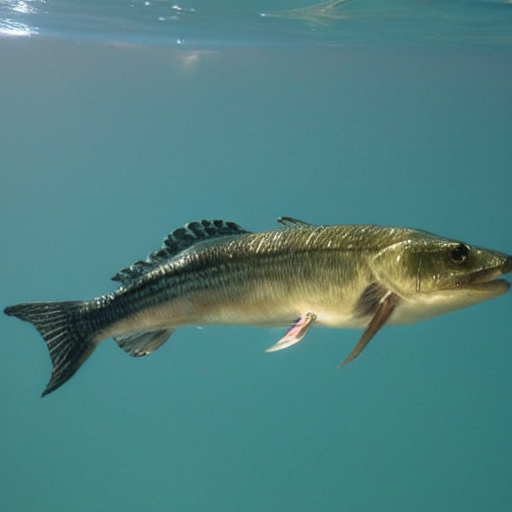

In [11]:
from IPython.display import Image
Image("job-a2252a15/combined_results/outputs/image0.png")

Install our dependencies for this example project

In [1]:
!pip install git+https://github.com/fchollet/stable-diffusion-tensorflow --upgrade --quiet
!pip install tensorflow tensorflow_addons ftfy --upgrade --quiet
!pip install tqdm
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

     |████████████████████████████████| 588.3 MB 22 kB/s 
     |████████████████████████████████| 1.1 MB 53.8 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 1.7 MB 50.0 MB/s 
     |████████████████████████████████| 6.0 MB 54.0 MB/s 
     |████████████████████████████████| 439 kB 70.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 9 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,392 MB disk space will 

Let's test the code we'll use - this is a tensorflow implementation of stable diffusion

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


1356917/1356917 [==============================] - 0s 0us/step


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


198152112/198152112 [==============================] - 9s 0us/step


  0   1: 100%|██████████| 50/50 [01:17<00:00,  1.54s/it]


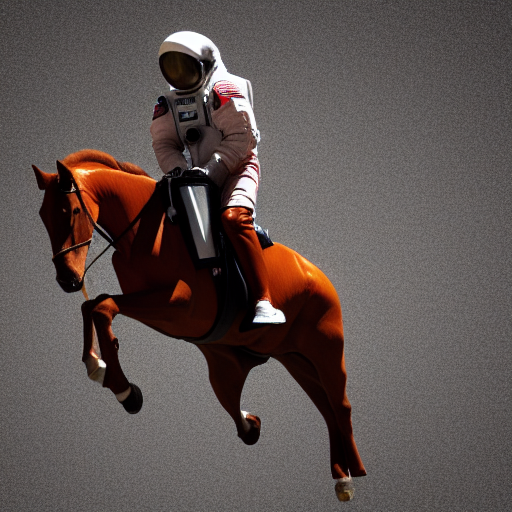

In [12]:
from stable_diffusion_tf.stable_diffusion import Text2Image
from PIL import Image

generator = Text2Image( 
    img_height=512,
    img_width=512,
    jit_compile=False,  # You can try True as well (different performance profile)
)
img = generator.generate(
    "DSLR photograph of an astronaut riding a horse",
    num_steps=50,
    unconditional_guidance_scale=7.5,
    temperature=1,
    batch_size=1,
)
pil_img = Image.fromarray(img[0])
display(pil_img)

Clean up the GPU RAM usage

In [13]:
!pip install numba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
# clearing the GPU memory 
from numba import cuda 
device = cuda.get_current_device()
device.reset()

Let's make a script that takes inputs!

In [15]:
%%writefile main.py
import argparse
from stable_diffusion_tf.stable_diffusion import Text2Image
from PIL import Image
import os
parser = argparse.ArgumentParser(description="Stable Diffusion")
parser.add_argument("--h",dest="height", type=int,help="height of the image",default=512)
parser.add_argument("--w",dest="width", type=int,help="width of the image",default=512)
parser.add_argument("--p",dest="prompt", type=str,help="Description of the image you want to generate",default="cat")
parser.add_argument("--n",dest="numSteps", type=int,help="Number of Steps",default=50)
parser.add_argument("--u",dest="unconditionalGuidanceScale", type=float,help="Number of Steps",default=7.5)
parser.add_argument("--t",dest="temperature", type=int,help="Number of Steps",default=1)
parser.add_argument("--b",dest="batchSize", type=int,help="Number of Images",default=1)
parser.add_argument("--o",dest="output", type=str,help="Output Folder where to store the Image",default="./")

args=parser.parse_args()
height=args.height
width=args.width
prompt=args.prompt
numSteps=args.numSteps
unconditionalGuidanceScale=args.unconditionalGuidanceScale
temperature=args.temperature
batchSize=args.batchSize
output=args.output

generator = Text2Image(
    img_height=height,
    img_width=width,
    jit_compile=False,  # You can try True as well (different performance profile)
)

img = generator.generate(
    prompt,
    num_steps=numSteps,
    unconditional_guidance_scale=unconditionalGuidanceScale,
    temperature=temperature,
    batch_size=batchSize,
)
for i in range(0,batchSize):
  pil_img = Image.fromarray(img[i])
  image = pil_img.save(f"{output}/image{i}.png")


Writing main.py


Let's run our new script!

In [17]:
!python main.py

2022-12-09 03:50:27.081214: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2022-12-09 03:50:27.081461: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2022-12-09 03:50:27.081487: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow ver

Let's see our image!

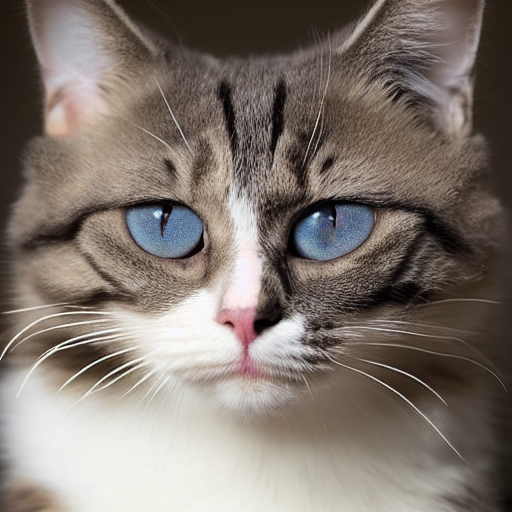

In [19]:
import IPython.display as display
display.Image("image0.png")

Let's try it with some of the arg's we added, like a different prompt and batchsize (number of images it creates)

In [21]:
!python main.py --p "cat with three eyes" --b 2

2022-12-09 03:55:01.003969: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2022-12-09 03:55:01.004184: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2022-12-09 03:55:01.004225: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow ver

Let's see what we got!

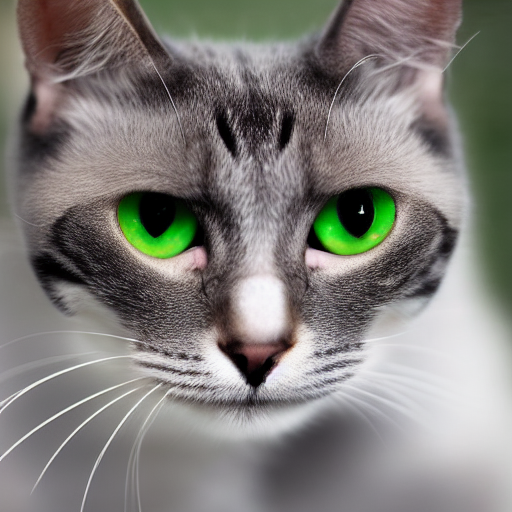

In [24]:
import IPython.display as display
display.Image("image0.png")
display.Image("image1.png")

I think we can do a little better with the script and image naming....

In [25]:
%%writefile stable-diffusion.py
import argparse
from stable_diffusion_tf.stable_diffusion import Text2Image
from PIL import Image
import os
parser = argparse.ArgumentParser(description="Stable Diffusion")
parser.add_argument("--h",dest="height", type=int,help="height of the image",default=512)
parser.add_argument("--w",dest="width", type=int,help="width of the image",default=512)
parser.add_argument("--p",dest="prompt", type=str,help="Description of the image you want to generate",default="cat")
parser.add_argument("--n",dest="numSteps", type=int,help="Number of Steps",default=50)
parser.add_argument("--u",dest="unconditionalGuidanceScale", type=float,help="Number of Steps",default=7.5)
parser.add_argument("--t",dest="temperature", type=int,help="Number of Steps",default=1)
parser.add_argument("--b",dest="batchSize", type=int,help="Number of Images",default=1)
parser.add_argument("--o",dest="output", type=str,help="Output Folder where to store the Image",default="./")

args=parser.parse_args()
height=args.height
width=args.width
prompt=args.prompt
numSteps=args.numSteps
unconditionalGuidanceScale=args.unconditionalGuidanceScale
temperature=args.temperature
batchSize=args.batchSize
output=args.output

generator = Text2Image(
    img_height=height,
    img_width=width,
    jit_compile=False,  # You can try True as well (different performance profile)
)

img = generator.generate(
    prompt,
    num_steps=numSteps,
    unconditional_guidance_scale=unconditionalGuidanceScale,
    temperature=temperature,
    batch_size=batchSize,
)
for i in range(0,batchSize):
  pil_img = Image.fromarray(img[i])
  image = pil_img.save(f"{output}/{prompt}{i}.png")


Writing stable-diffusion.py


Let's try it

In [27]:
!python stable-diffusion.py --p "great dane in Paris" --b 2

2022-12-09 04:00:42.532583: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2022-12-09 04:00:42.532719: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2022-12-09 04:00:42.532742: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow ver

Show me what you got!

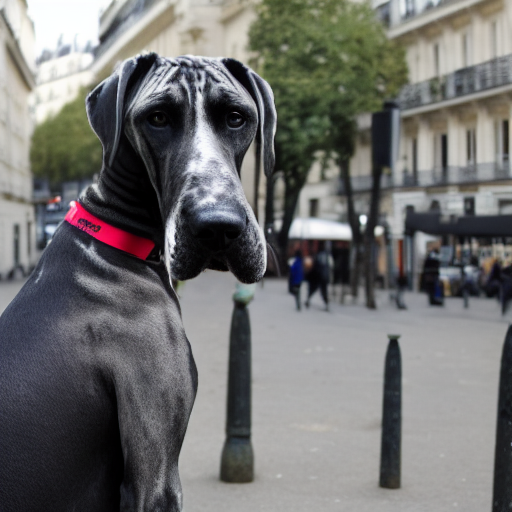

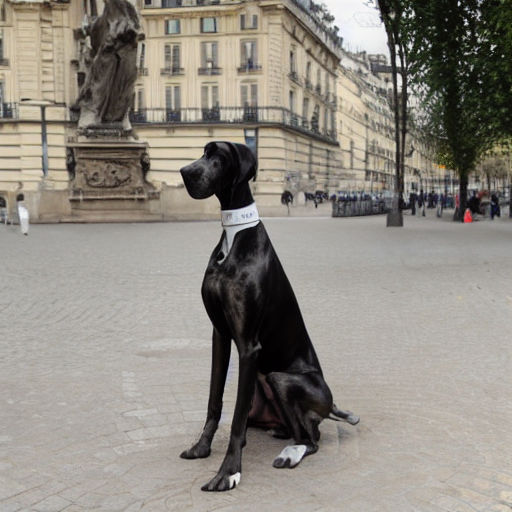

In [32]:
from IPython.display import Image
from IPython.display import display
x = Image(filename="great dane in Paris0.png")
y = Image(filename="great dane in Paris1.png")
display(x,y)

We can't use Docker in Colab so unfortunately we have to move our tested code into an IDE and upload from our own local machine.